In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import qcodes as qc
import os
from qcodes import (Measurement,
                    experiments,
                    initialise_database,
                    initialise_or_create_database_at,
                    load_by_guid,
                    load_by_run_spec,
                    load_experiment,
                    load_last_experiment,
                    load_or_create_experiment,
                    new_experiment,
                    ManualParameter)
import matplotlib.pyplot as plt

db_name = "../data/GeSiNW_fully_autonomous_tuning.db" # Database name

db_file_path = os.path.join(os.getcwd(), db_name)
qc.config.core.db_location = db_file_path
initialise_or_create_database_at(db_file_path)

plt.style.use('default')
import sys
sys.path.append('../')

# Load data

In [2]:
# local_ids = [709]
# from qcodes.dataset import (
#     Measurement,
#     connect,
#     extract_runs_into_db,
#     load_experiment_by_name,
#     load_or_create_experiment,
# )
# source_conn = connect(db_name)
# target_path = "../data/GeSiNW_fully_autonomous_tuning.db"
# target_conn = connect(target_path)
# for _id in local_ids:
#     extract_runs_into_db(db_name, target_path, _id)

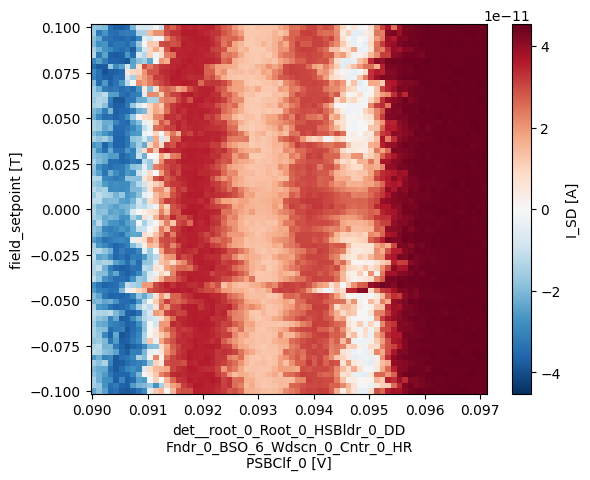

In [3]:
ds = load_by_guid('43222256-0000-0000-0000-018a80eef002')
ds.to_xarray_dataset()["I_SD"].plot()
data_xarray = ds.to_xarray_dataset()

# Apply method

peaks found: (33, 0.00153846153846153)
Peak foundpeaks: 0.00153846153846153, peak_offset_tolerance: 0.025


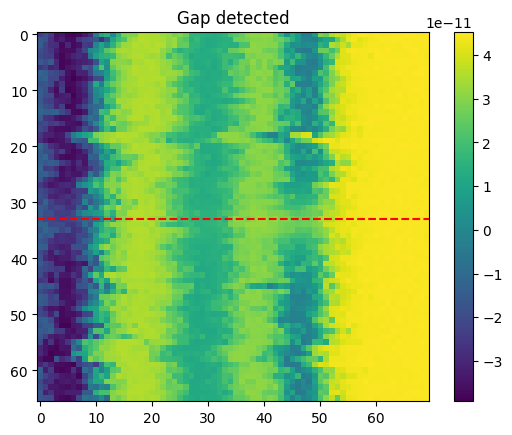

In [4]:
from signal_processing.danon_gap_detector.danon_gap_detector import DanonGapDetector

configs = {'field_gap_size': 0.002, 'relative_depth': 1.0}
# method = 'MF' # [OU, MF]
# sigma = 1

invert_current = True

# we want to see a peak, so do opposite of what the flag says
if not invert_current:
    data_analysis = -data_xarray["I_SD"]
else:
    data_analysis = data_xarray["I_SD"]

axes_values = []
axes_values_names = []
axes_units = []

for item, n in dict(data_xarray.dims).items():
    axes_values.append(data_xarray[item].to_numpy())
    axes_values_names.append(data_xarray[item].long_name)
    axes_units.append(data_xarray[item].unit)

dg_detector = DanonGapDetector(**configs)
peaks, fig = dg_detector.get_gap_location(data_analysis)

peak_of_magnet = axes_values[0][peaks]
print(f"peaks found: {peaks, peak_of_magnet}")
peak_offset_tolerance = 0.025
filename = "danon_gap_msmt"
gap_found = False
if peaks == None:
    message = "No peaks found. Assume no PSB."
else:
    if abs(peak_of_magnet) < peak_offset_tolerance:
        message = (
            f"Peak found"
            f"peaks: {peak_of_magnet}, peak_offset_tolerance: {peak_offset_tolerance}"
        )
        gap_found = True
    else:
        message = (
            f"Peaks found in unexpected place. Assume it is noise."
            f"peaks: {peak_of_magnet}, peak_offset_tolerance: {peak_offset_tolerance}"
        )
print(message)